In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
# sns.set(font_scale=1.5) 

house_df_org = pd.read_csv(r'D:\Python\house_price.csv')
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


- 79개의 변수로 구성된 이 데이터는 미국 아이오와 주의 에임스(Ames) 지방의 주택 가격 정보를 가지고 있다.
- 성능 평가는 RMSLE(Root Mean Squared Log Error)를 기반으로 함
- 이는 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이것을 상쇄하기 위해 오류 값을 로그 변환한 RMSLE를 이용함

# 데이터 사전 처리(Preprocessing)
- Target 값은 맨 마지막 칼럼인 SalePrice.
- 데이터의 전체 크기와 컬럼 타입, Null이 있는 컬럼과 그 건수를 내림차순으로 출력

In [2]:
print('데이터 세트의 Shape: ', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수: \n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape:  (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


- 데이터 세트는 총 1460개의 레코드와 81개의 피처로 구성돼 있으며, 피처 타입은 숫자형과 문자형이 섞여있음
- Target을 제외한 80개의 피처중 43개가 문자형이며 나머지가 숫자형
- 데이터의 양에 비해 Null 값이 많은 피처도 있다.
- 전체 1480개 데이터 중 PoolQC, MiscFeature, Alley, Fence는 Null값이 너무 많으므로 삭제할 예정

<br>

- 회귀모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지를 확인

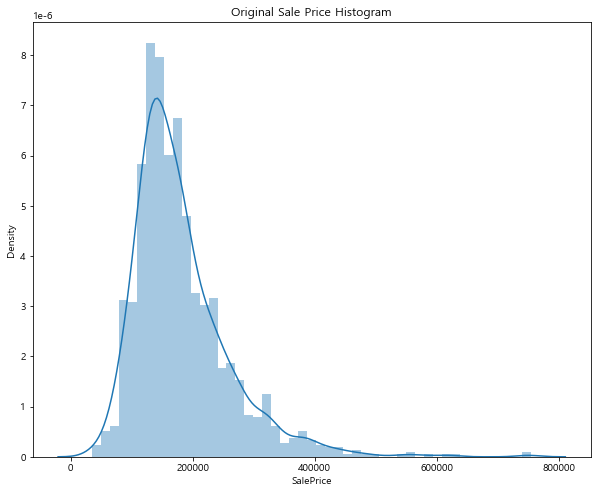

In [3]:
# 히스토그램은 관찰값(연속적 자료)을 구간등급으로 세분화해 그에 대한 빈도수를 체크하는 그래프이다.
# 연속적 자료의 관찰값의 분포를 살펴보기 쉽다.

plt.figure(figsize=(10, 8))
sns.distplot(house_df['SalePrice'])
plt.title('Original Sale Price Histogram');

- Target 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로, 정규분포에서 벗어나 있음
- 정규분포가 아닌 결괏값을 정규 분포 형태로 변환하기 위해 로그 변환(Log Transformation)을 적용
- 먼저 넘파이의 log1p( )를 이용해 로그 변환한 결괏값을 기반으로 학습한 뒤, 예측 시에는 다시 결괏값을 expm1( )으로 추후에 환원하면 됨

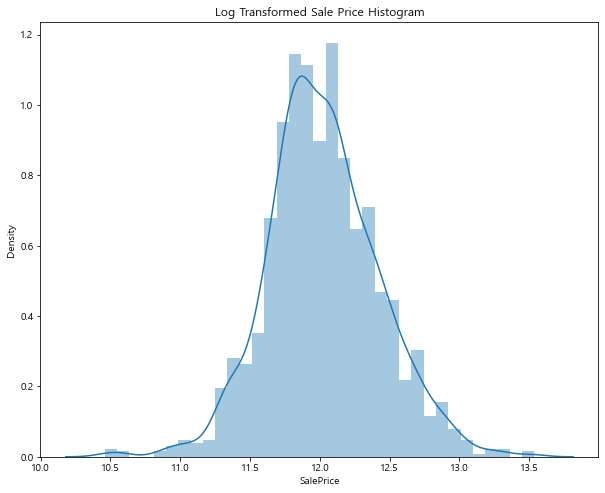

In [4]:
plt.figure(figsize=(10, 8))
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice);

- SalePrice를 로그 변환해 정규 분포 형태로 결괏값이 분포함을 확인
- SalePrice를 로그 변환 후 DataFrame에 반영
- 또한 Null 값이 많은 컬럼과 Id(단순 식별자)를 제거
- 나머지 Null 피처는 Null 값이 많지 않으므로 숫자형의 경우 평균값으로 대체

In [5]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 컬럼과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], 
              axis=1, inplace=True)

# 드롭하지 않은 숫자형 Null 컬럼은 평균값으로 대체
# mean( ) 메서드는 자동으로 숫자형 컬럼만 추출해 컬럼별 평균값을 Series 객체로 반환
house_df.fillna(house_df.mean(), inplace=True)

In [6]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


- 문자형 피처는 모두 원-핫 인코딩화 (pd.get_dummies( ))
- get_dummies( )는 자동으로 문자열 피처를 원-핫 인코딩 변환하면서 Null값은 'None'칼럼의로 대체해주기 때문에 별도의 Null값을 대체하는 로직이 필요없음
- 원-핫 인코딩을 적용하면 컬럼은 증가

In [7]:
print('get_dummies( ) 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies( ) 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies( ) 수행 전 데이터 Shape: (1460, 75)
get_dummies( ) 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type: 
 Series([], dtype: object)


# 선형 회귀 모델 학습/예측/평가
- 이 모델의 예측 평가는 RMSLE( 실제 값과 예측 값의 오류를 로그변환한뒤 RMSE를 적용 )
- 그런데 이미 타깃값인 SalePrice가 로그 변환이 되었음
- 예측값 역시 로그 변환된 SalePrice값을 기반으로 예측하므로 원본 SalePrice 예측값의 로그 변환값
- 실제 값도 로그 변환하였으며 예측값도 이를 반영한 로그 변환 값이므로 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 축정

In [8]:
# 여러 모델의 로그 변환된 RMSE를 측정할 것이므로 이를 계산하는 함수 생성
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                    test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154713, 0.12750846334053048, 0.17628250556471403]

- 라쏘 회귀의 경우 회귀 성능이 타 회귀 방식보다 많이 떨어짐 -> 최적 하이퍼 파라미터 튜닝이 필요

<br>

- 피처가 많으니 회귀 계수 값의 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 Series를 반환하는 함수

In [10]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    
    return coef_high, coef_low

- 생성한 get_top_bottoms(model, n=10) 함수를 이용해 모델별 회귀 계수를 시각화하는 함수 생성

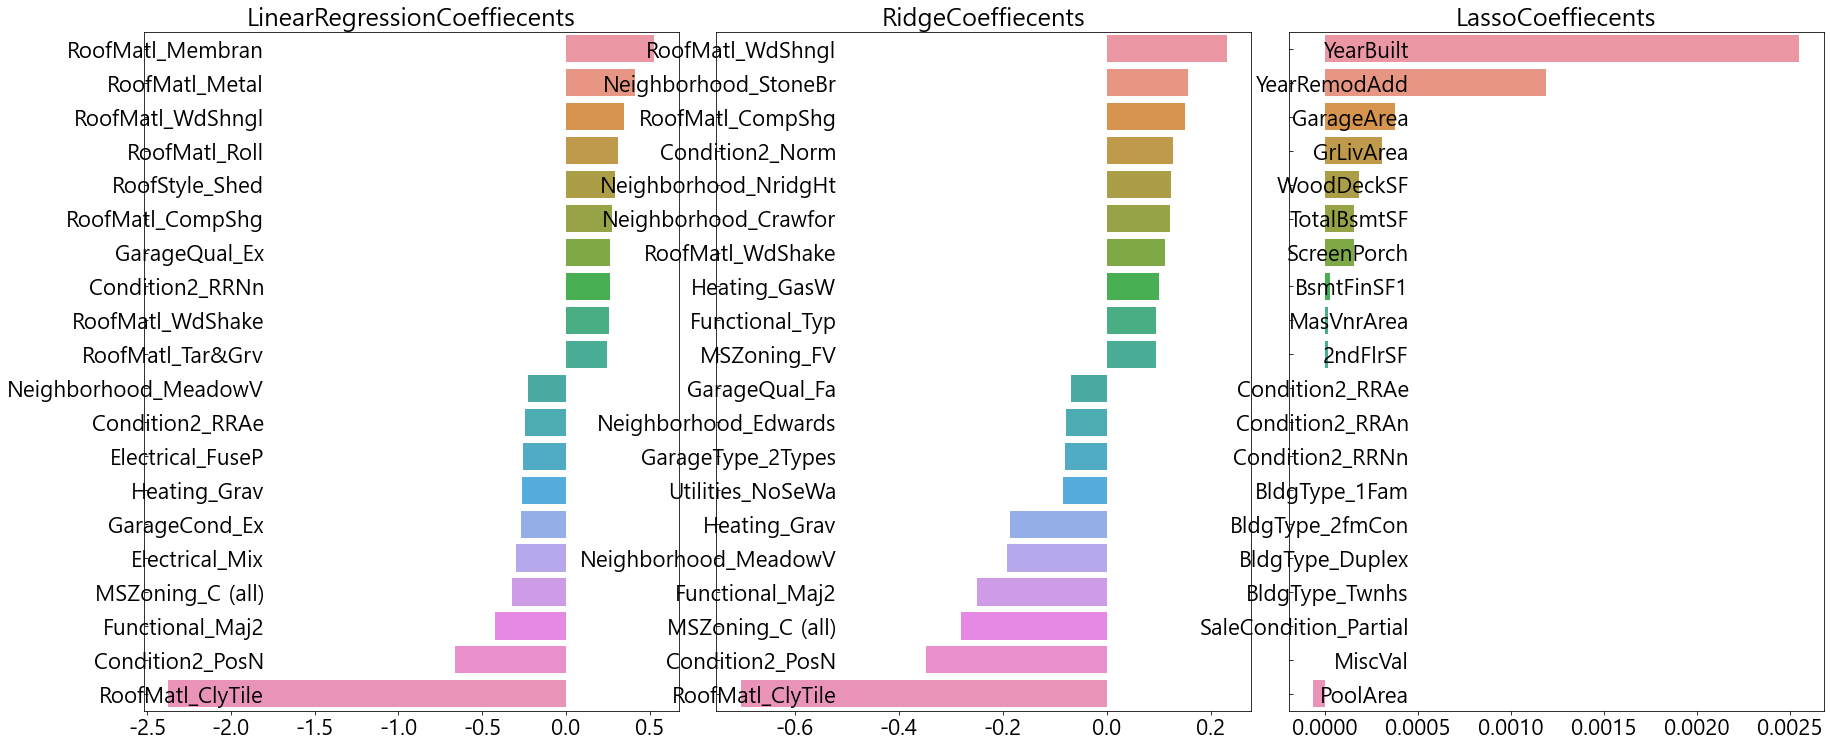

In [11]:
def visualize_coefficient(models):
    # 3개의 회귀 모델의 시각화를 위해 3개이 컬럼을 가지는 sunplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high, coef_low] )
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__+'Coeffiecents', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- LinearRegression과 Ridge의 경우 회귀 계수가 유사한 형태로 분포로 이루어짐
- 하지만 라쏘(Lasso)는 전체적으로 회귀 계수 값이 매우 작고, 구증에 YearBuilt가 가장 크고 다른 피처의 회귀 계수는 너무 작음

<br>

- 학습데이터의 데이터 분할에 문제가 있어서 있는지를 확인하기 위해 전체 데이터 세트를 5개의 교차 검증 폴트 세트로 분할해 평균 RMSE를 측정

In [12]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, 
                                            scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
        
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


- 5개의 폴드 세트로 학습한 후 평가해도 여전히 라쏘의 경우가 OLS 모델이나 릿지 모델보다 성능이 떨어짐
- 릿지와 라쏘 모델에 대해서 alpha 하이퍼 파라미터를 변화시키면서 최적의 값을 도출해보겠음

<br>

- 모델별로 최적화 하이퍼 파라미터 작업을 반복적으로 진행하기 위한 함수 생성
- print_best_params(model, params)는 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과를 표시하는 함수

In [13]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha: {2}'.format(model.__class__.__name__,
                                                                    np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha: {'alpha': 0.001}


- 라쏘 모델의 경우, alpha 값 최적화 이후 예측 성능이 많이 좋아졌음
- 선형 모델에 최적 alpha 값을 설정한 뒤, train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가를 수행하고, 모델별 회귀 계수를 시각화

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


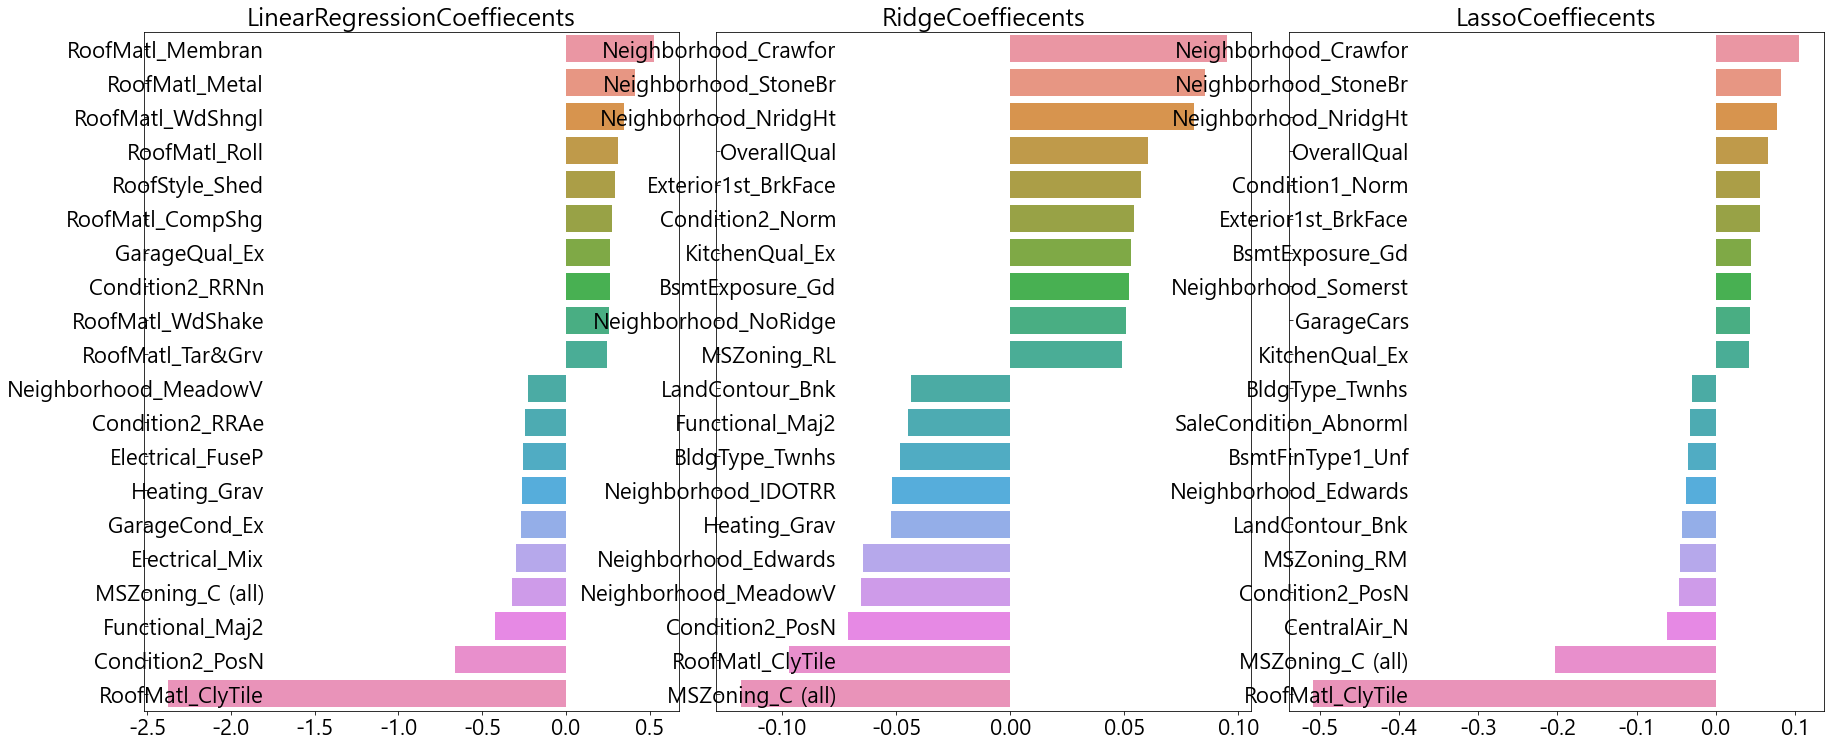

In [14]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- alpha 값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아졌으며 모델별 회귀 계수도 많이 달라졌음
- 기존에는 라쏘 모델의 회귀 계수가 나머지 두 개 모델과 많은 차이가 있었지만, 이번에는 릿지와 라쏘모델에서 비슷한 피처의 회귀 계수가 높다.
- 다만 라쏘 모델의 경우는 릿지에 비해 동일한 피처라도 회귀 계수의 값이 상당히 작다.

<br>

- 데이터 세트를 추가적으로 가공해서 모델 튜닝하기
    1. 피처 데이터 세트의 데이터 분포도 확인
    2. 이상치(Outlier) 데이터 처리  

<br>

- 피처 데이터 세트의 경우도 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하시킬수 있다.
- 모든 숫자형 피처의 데이터 분포도를 확인해 분포도가 어느 정도로 왜곡됐는지 확인해보겠다.
- 사이파이 stats 모듈의 skew( )함수를 이용해 왜곡된 정도를 추출할 수 있는데 일반적으로 반환값이 1 이상인 경우를 왜곡 정도가 높다고 판단함( 상황마다 편차가 존재함 )
- 여기서는 1 이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 로그 변환을 적용하겠다.

<br>

- 한가지 주의할 점은
    - skew( )를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외해야 함
    - 카테고리 피처는 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높음
    - 따라서 skew( ) 함수를 적용하는 DataFrame은 원-핫 인코딩이 적용된 house_df_ohe가 아니라 원-핫 인코딩이 적용되지 않은 house_df이어야 함

In [15]:
from scipy.stats import skew

# Object가 아닌 숫자형 피처의 컬럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))
# skew(왜곡) 정도가 1 이상인 컬럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [16]:
# 추출된 왜곡 정도가 높은 피처를 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

- 로그 변환 후 이 피처들의 왜곡 정도를 다시 확인해보면 여전히 높은 왜곡 정도를 가진 피처가 있지만 더이상 로그 변환을 하더라도 개선하기 어렵기에 그대로 유지
- house_df의 피처를 일부 로그 변환했으므로 다시 원핫인코딩을 적용한 house_df_ohe를 만름
- 그리고 이렇게 만든 데이터 세트에 다시 앞에서 만든 print_best_params()함수를 이용해 최적 alpha 값과 RMSE를 출력

In [17]:
# 왜곡 정도가 높은 피처를 로그변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트를 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                    test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


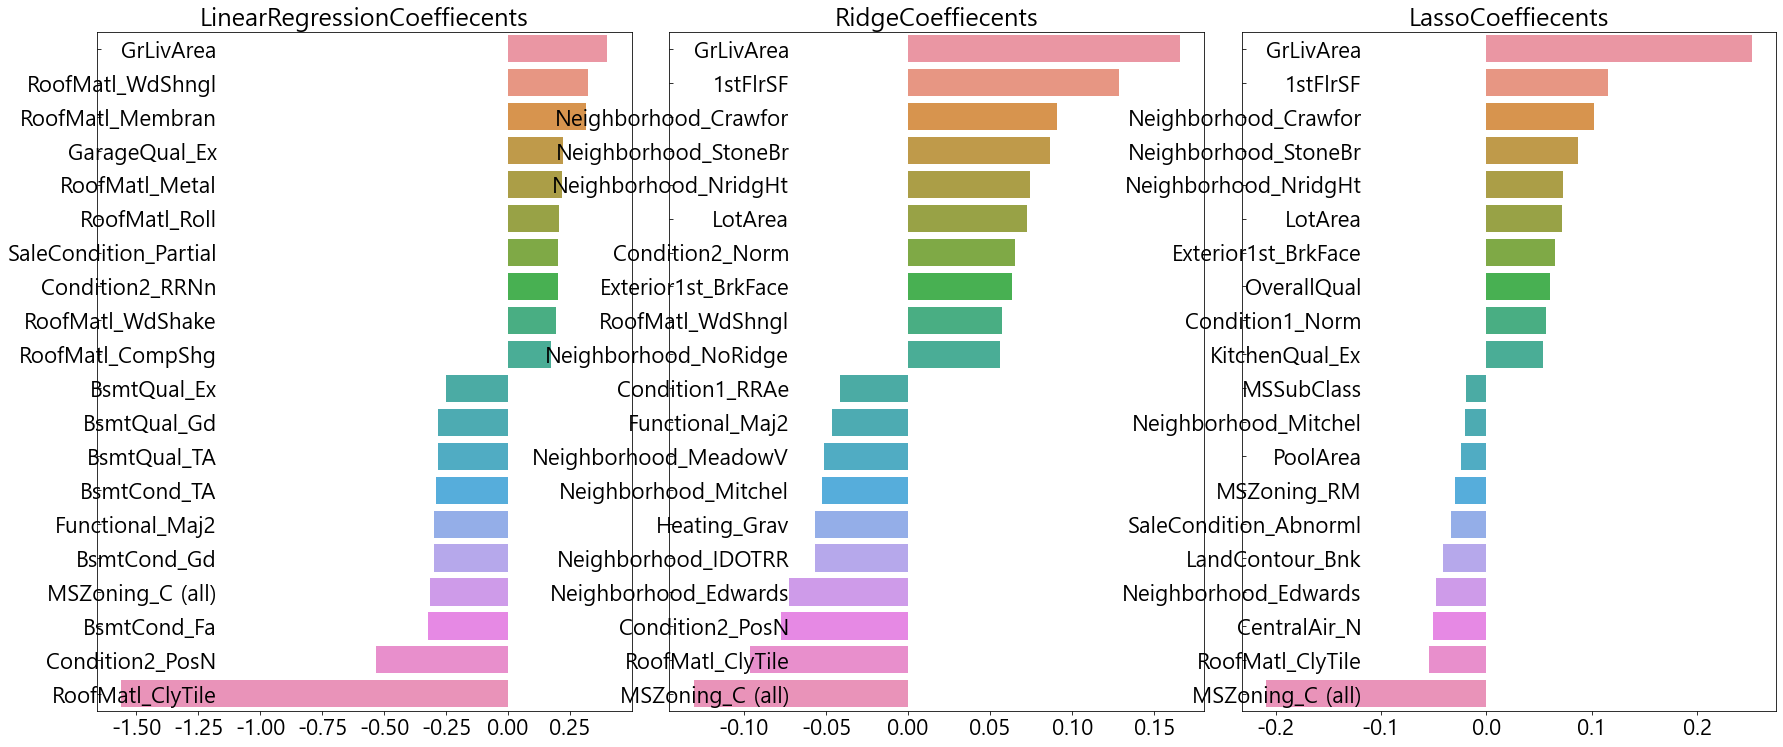

In [18]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 릿지 모델의 경우 최적 alpha값이 12에서 10으로 변경됐고, 두 모델 모두 피처의 로그 변환 이전과 비교해 5 폴드 교차 검증의 평균 RMSE 값이 향상되었음
    - 릿지의 경우 0.1418에서 0.1275, 
    - 라쏘의 경우 0.142에서 0.1252  
- 회귀 계수 시각화결과를 보면 세 모델 모두 GrLiv Area, 즉 주거 공간 크기가 회귀계수가 가장 높은 피처가 되었음
- 주거 공간의 크기가 주택 가격에 미치는 영향이 당연히 제일 높은 것이라는 상식선에서의 결과가 이제야 도출 되었음

- 다음으로 분석할 요소는 이상치 데이터
- 특히 회귀계수가 높은 피처, 즉 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터 처리가 중요함
- 먼저 가장 큰 회귀 계수를 가지는 GrLivArea 피처의 데이터 분포를 살펴보겠음

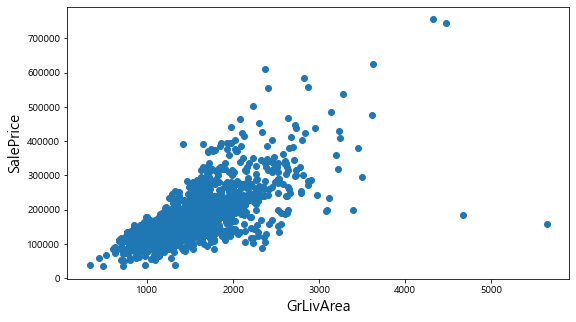

In [19]:
plt.figure(figsize=(9, 5))
plt.scatter(x= house_df_org['GrLivArea'], y= house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15);

- 일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 GrLivArea피처는 SalePrice와 양의 상관도가 매우 높음을 직관적으로 알수 있다.
- 그러나 몇몇 데이터가 GriLivArea와 SalePrice 관계에서 너무 어긋나 있다.
- GriLivArea가 4000평방피트 이상임에도 가격이 500,000달러 이하인 데이터는 모두 이상치로 간주하고 삭제해야 함

<br>

- 데이터 변환이 모두 완료된 house_df_ohe에서 대상 데이터를 필터링
- GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건을 생성한 뒤, 불린 인덱싱으로 대상을 탐색
- 찾은 데이터의 인덱스와 drop( )을 이용해 해당 데이터를 삭제

In [20]:
# GriLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index: ', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape: ', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape: ', house_df_ohe.shape)

이상치 레코드 index:  [ 523 1298]
이상치 삭제 전 house_df_ohe shape:  (1460, 271)
이상치 삭제 후 house_df_ohe shape:  (1458, 271)


In [21]:
# 릿지, 라쏘 모델의 최적화
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                    test_size=0.2, random_state=156)

ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha: {'alpha': 0.001}


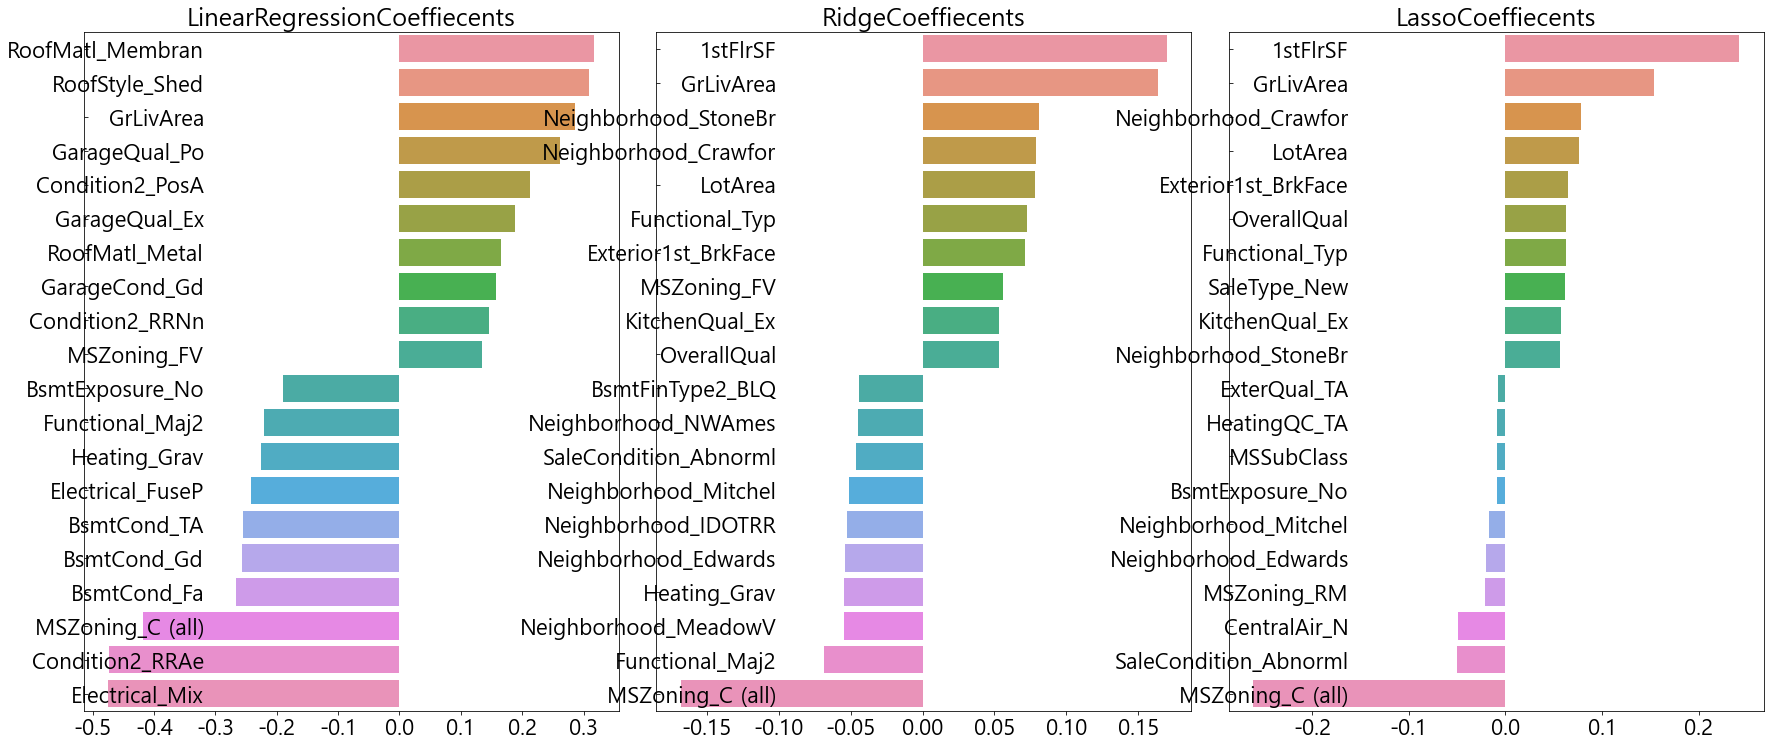

In [22]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 이상치를 제거후
    - 릿지: 0.1275 -> 0.1125
    - 라쏘: 0.128 -> 0.114
- GrLivArea 속성이 회귀 모델에서 차지하는 영향력도가 크기에 이 이상치를 개선하는 것이 성능 개선에 큰 의미를 가짐
- 회귀에 중요한 영향을 미치는 피처를 위주로 이상치 데이터를 찾으려는 노력은 중요함
- 보통 머신러닝 프로세스 중에서 데이터의 가공은 알고리즘을 적용하기 이전에 수행하지만 알고리즘 적용 이전에 완벽하게 데이터 선처리 작업을 수행하라는 뜻은 아님
- 대략의 데이터 가공과 모델 최적화를 수행한 뒤 다시 이에 기반한 여러가지 기법의 데이터 가공과 하이퍼 파라미터 기반의 모델 최적화를 반복적으로 수행하는 것이 바람직한 머신러닝 모델 생성 과정

# 회귀 트리 모델 학습/예측/평가
- XGBoost와 LightGBM을 이용한 모델 생성

In [23]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1178, 최적 alpha: {'n_estimators': 1000}


In [24]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate = 0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1163, 최적 alpha: {'n_estimators': 1000}


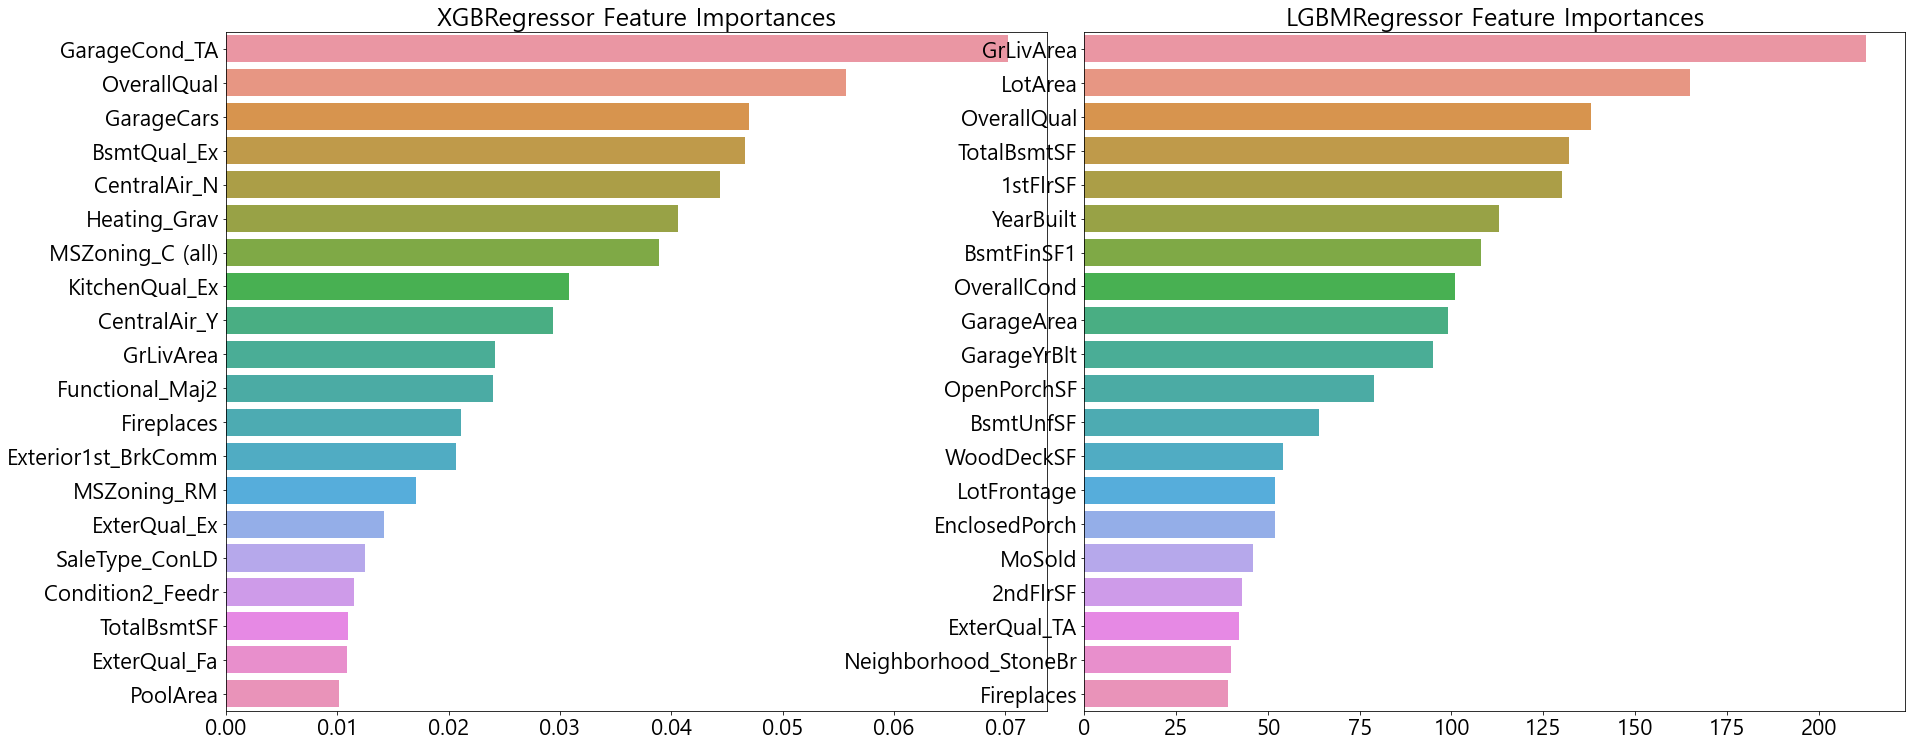

In [29]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 get_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화  
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

models = [xgb_reg, lgbm_reg]
visualize_ftr_importances(models)

# 회귀 모델의 예측 결과 혼합을 통한 최종 예측
- 이번에는 개별 회귀 모델의 예측 결괏값을 혼합해 이를 기반으로 최종 회귀 값을 예측
- 가령 A 모델과 B 모델, 두 모델의 예측값이 있다면 A 모델 예측값의 40%, B 모델 예측값의 60%를 더해서 최종 회귀 값으로 예측하는 것
- 앞에서 구한 릿지 모델과 라쏘 모델을 서로 혼합할 예정
- 최종 혼합 모델, 개별 모델의 RMSE 값을 출력하는 get_rmse_pred( ) 함수를 생성하고 각 모델의 예측값을 계산하여 개별 모델과 최종 혼합 모델의 RMSE를 구함

In [30]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))
        
# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred, 
         'Lasso': lasso_pred }

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470499
Ridge 모델의 RMSE: 0.10345177546603232
Lasso 모델의 RMSE: 0.10024170460890024


In [31]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred= lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
pred= {'최종 혼힙':pred,
       'XGBM':xgb_pred,
       'LGBM':lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470499
Ridge 모델의 RMSE: 0.10345177546603232
Lasso 모델의 RMSE: 0.10024170460890024
